In [1]:
import cv2
import matplotlib.pyplot as plt
from torchvision.ops import roi_align
import torch
import sys
import torch
sys.path.append('../ultralytics')
sys.path.append('../tools')

import ultralytics

img = cv2.imread('../data/vasculature/images/0a1d277fb473.jpg')[:, :, ::-1]
# plt.imshow(img)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
from tool_utils import load_annotations, auto_ann_path
import pandas as pd

df = pd.read_csv("../data.csv")
anns = load_annotations("../data/vasculature/polygons.jsonl", indexing=True)

In [14]:
df.head(3)

,id,has_annotation,source_wsi,dataset,fold
0,8a60272c70aa,True,1,2,3
1,2d5459d56621,True,3,2,1
2,af587261a215,True,1,1,1


In [20]:
def count_obj(row):
    count = {'blood_vessel': 0, 'unsure': 0, 'glomerulus': 0}
    ann = anns.get(row['id'])['annotations']
    for b in ann:
        count[b['type']] += 1
    for k, v in count.items():
        row[k] = v
    return row

df = df.apply(count_obj, axis=1)
df.head(3)

,id,has_annotation,source_wsi,dataset,fold,blood_vessel,unsure,glomerulus
0,8a60272c70aa,True,1,2,3,11,0,1
1,2d5459d56621,True,3,2,1,7,0,0
2,af587261a215,True,1,1,1,5,3,0


In [40]:
print("Total annotation per Source wsi")
for dataset, df_ in df.groupby(("source_wsi")):
    print(f"source {dataset} ({len(df_)})\n", df_[["blood_vessel", "unsure", "glomerulus"]].sum())
    print("---")


Total annotation per Source wsi
source 1 (507)
 blood_vessel    4080
unsure           499
glomerulus       126
dtype: int64
---
source 2 (445)
 blood_vessel    5213
unsure           398
glomerulus       140
dtype: int64
---
source 3 (410)
 blood_vessel    4691
unsure             0
glomerulus       204
dtype: int64
---
source 4 (271)
 blood_vessel    2070
unsure             0
glomerulus        97
dtype: int64
---


In [36]:
df.sort_values('blood_vessel')

,id,has_annotation,source_wsi,dataset,fold,blood_vessel,unsure,glomerulus
550,f48f6580655c,True,1,1,3,0,3,0
1376,18be061202ea,True,1,2,1,0,1,0
443,d1d485660263,True,1,1,1,0,3,0
46,8f256d18b5e4,True,1,1,3,0,4,0
1379,ba276097772d,True,1,2,2,0,1,0
...,...,...,...,...,...,...,...,...
1319,32e007559fb4,True,2,1,2,38,0,0
309,f38f2f72a1b7,True,2,1,1,40,8,0
1491,611599949a53,True,2,1,4,44,4,0
1384,38ff92c9ae72,True,1,2,1,44,0,0


In [ ]:
from itertools import product

import numpy as np
cuts = 4
W, H = 512, 512
wstarts = W * np.arange(cuts).astype(int) // (cuts + 1)
wends = W * np.arange(2, cuts + 2).astype(int) // (cuts + 1)
hstarts = H * np.arange(cuts).astype(int) // (cuts + 1)
hends = H * np.arange(2, cuts + 2).astype(int) // (cuts + 1)
for i, j in product(range(cuts), range(cuts)):
    y1,y2,x1,x2, = hstarts[i], hends[i],wstarts[j],wends[j]
    cut = img[y1:y2,x1:x2]
    print(x1,x2,y1,y2, x2 - x1)
    cv2.imwrite(f"cut_{x1}_{y1}_{x2}_{y2}.png", cut)

In [345]:
import os
from glob import glob

def get_img_path_bboxes(p):
    dirname = os.path.dirname(p)
    fname = os.path.basename(p)
    fname = os.path.splitext(fname)[0].replace("mask_", "")
    x1, y1, x2, y2, img_id = fname.split("_")
    return os.path.join(dirname, f"img_{img_id}.npy"),p, [int(float(x)) for x in [x1, y1, x2, y2]]

dir_ = "../segmentation/.cache"

masks = [x for x in glob(f"{dir_}/*") if "mask_" in x]
get_img_path_bboxes(masks[0]), len(masks)

(('../segmentation/.cache/img_394b6b4f803d.npy',
  '../segmentation/.cache/mask_431_42_456_68_394b6b4f803d.npy',
  [431, 42, 456, 68]),
 1307)

In [346]:
def random_shift(x1, y1, x2, y2, shift_ratio):
    cr_w = x2 - x1 
    cr_h = y2 - y1
    shift_ratio = 0.0
    is_train = True

    if is_train:
        pad_left = random.randint(-1*int(shift_ratio*cr_w), int(shift_ratio*cr_w))
        pad_right = random.randint(-1*int(shift_ratio*cr_w), int(shift_ratio*cr_w))
        pad_top = random.randint(-1*int(shift_ratio*cr_h), int(shift_ratio*cr_h))
        pad_bot = random.randint(-1*int(shift_ratio*cr_h), int(shift_ratio*cr_h))
    else:
        pad_left = 0
        pad_right = 0
        pad_top = 0
        pad_bot = 0

    cr_x1 = round(max(0, x1-pad_left))
    cr_y1 = round(max(0, y1-pad_top))
    cr_x2 = round(min(im_w-1, x2+pad_right))
    cr_y2 = round(min(im_h-1, y2+pad_bot))
    return cr_x1, cr_y1, cr_x2, cr_y2

def expand_crop(x1, y1, x2, y2, img_h, img_w, ratio):
    # Make input square by compute padded crop
    w, h = x2 - x1,  y2 - y1
    if w > h:
        pad_x = (w * ratio) / 2
        pad_y = (w + pad_x * 2 - h) / 2
        print("C1", pad_x, pad_y)
    else:
        pad_y = (h * ratio) / 2
        pad_x = (h + pad_y * 2 - w) / 2
        print("C2", pad_x, pad_y)
        
    x1 = round(max(0, x1 - pad_x))
    y1 = round(max(0, y1 - pad_y))
    x2 = round(min(im_w - 1, x2 + pad_x))
    y2 = round(min(im_h - 1, y2 + pad_y))
    return x1, y1, x2, y2

255
(512, 512, 4)
C1 30.599999999999998 34.599999999999994


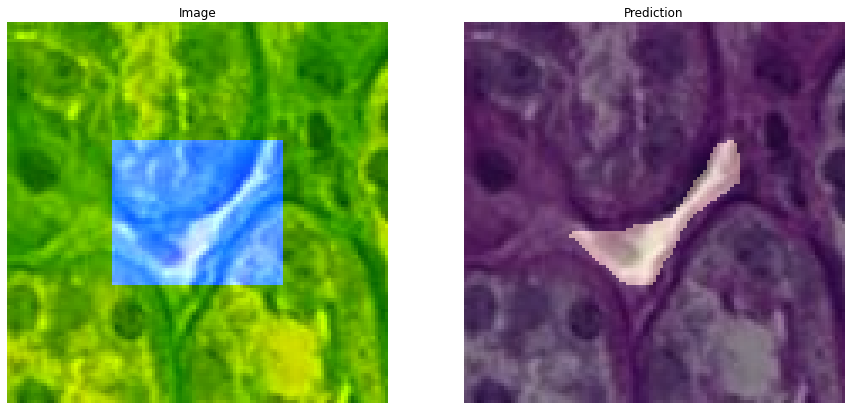

<Figure size 432x288 with 0 Axes>

In [418]:
import numpy as np
import random



img_path, mask_path, bboxes = get_img_path_bboxes(random.choice(masks))
bboxes = [int(x) for x in bboxes]
img = np.load(img_path)
mask = np.load(mask_path) # HW

im_h, im_w = img.shape[:2]

# all_mask = cv2.imread(f'{self.cfg.mask_dir}/{img_id}.png',0)
# all_mask = np.uint8(1*(all_mask>0))

x1, y1, x2, y2 = bboxes
print(img.max())
img = np.concatenate([img, np.zeros([*img.shape[:2], 1], dtype=img.dtype)], axis=2)
print(img.shape)
img[y1:y2, x1:x2, 3] = 255
x1, y1, x2, y2   = expand_crop(x1, y1, x2, y2,im_h, im_w, 1.2)
x1, y1, x2, y2 = random_shift(x1, y1, x2, y2, 0.4)


img = img[y1: y2, x1: x2]
mask = mask[y1: y2, x1: x2]

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.imshow(img[:,:,1:4])
plt.title('Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(img[:,:,:3])
plt.imshow(mask, alpha=0.4, cmap='inferno')
plt.title('Prediction')
plt.axis('off')
img_path, img.shape
plt.show()
plt.clf()

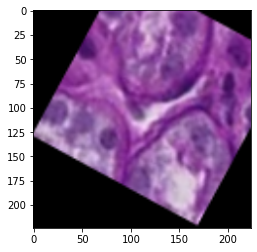

In [503]:
import albumentations as A

def train_transform(img_size):
    return A.Compose(
        [
            # A.RandomResizedCrop(img_size, img_size, scale=(0.5, 1.3), ratio=(0.8, 1.3), p=1.0),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
            # A.OneOf([
            #     A.GaussNoise(var_limit=[10, 50]),
            #     A.GaussianBlur(),
            #     A.MotionBlur(),
            # ], p=0.2),
            # A.RandomBrightnessContrast(
            #     brightness_limit=(-0.2, 0.2),
            #     contrast_limit=(-0.2, 0.2),
            #     p=0.5,
            # ),
            # geometric
             A.OneOf([
                A.ElasticTransform(
                    alpha_affine=10,
                    border_mode=cv2.BORDER_CONSTANT, p=1.2),
                # A.GridDistortion(num_steps=5, distort_limit=0.3, p=1),
            ], p=1.0),
            A.ShiftScaleRotate(
                shift_limit=0.1,
                scale_limit=[-0.15, 0.15],
                rotate_limit=[-30, 30],
                interpolation=cv2.INTER_LINEAR,
                border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=None,
                p=0.5
            ),
           
            # random erase
            A.CoarseDropout(max_holes=1, max_width=int(img_size * 0.3), max_height=int(img_size * 0.3), mask_fill_value=0, p=0.1),
            A.Resize(img_size, img_size),
        ]
    )
tf = train_transform(224)
img1 = tf(image=img[:,:,:3])['image']
plt.imshow(img1)